# Self-Driving Car Engineer Nanodegree


## Project: **Vechicle Detection and Tracking** 

The goal of this project is to write a software pipeline to detect vehicles in a video. This iPython Notebook contains all the steps I will follow for my vechicle detection pipeline project.

---

**Import Packages**

In [1]:
#importing some useful packages
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split
%matplotlib inline

/home/mlab-gaming/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


**Load Training Data**

In [2]:
# Read in vehicles and non-vehicles
cars = glob.glob('vehicles/vehicles/*/*.png')
notcars = glob.glob('non-vehicles/non-vehicles/*/*.png')

print("Total number of Car images: %d and non-car images: %d" %(len(cars), len(notcars)))

Total number of Car images: 8792 and non-car images: 8968


**Visualize some of these images**

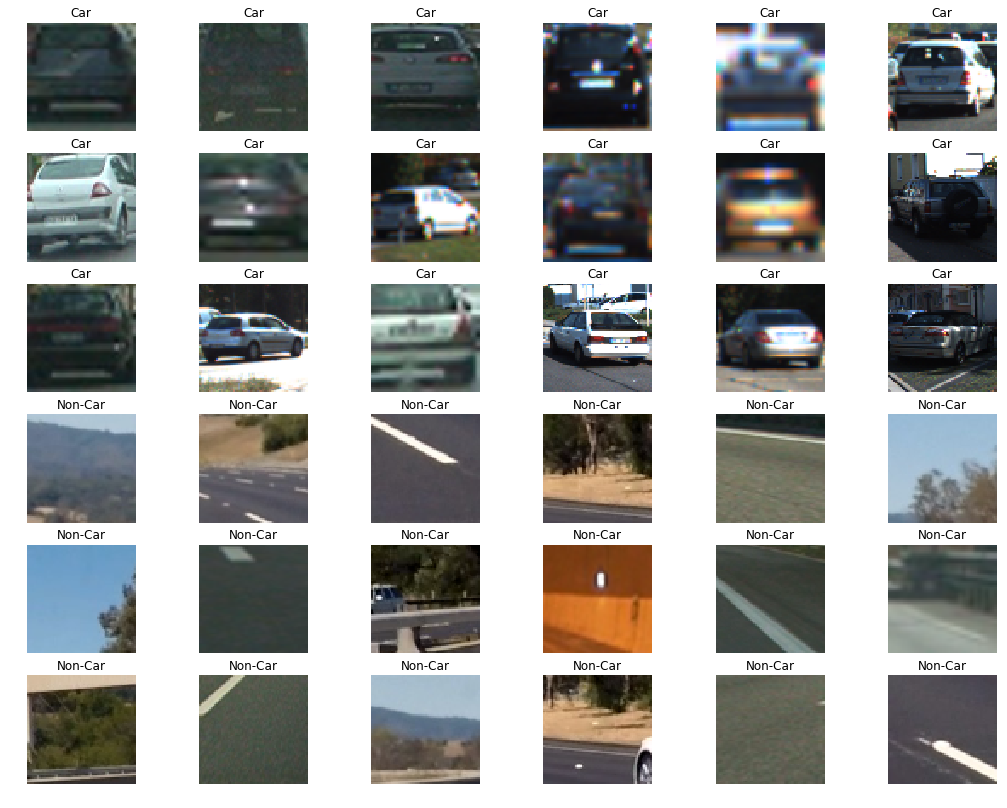

In [3]:
fig, axes = plt.subplots(6, 6, figsize=(18,14))
axes = axes.ravel()

for i in range(18):
    car_img = cv2.imread(cars[np.random.randint(0,len(cars))])
    car_img = cv2.cvtColor(car_img,cv2.COLOR_BGR2RGB)
    axes[i].axis('off')
    axes[i].imshow(car_img)
    axes[i].set_title("Car")

for i in range(18,36):
    notcar_img = cv2.imread(notcars[np.random.randint(0,len(notcars))])
    notcar_img = cv2.cvtColor(notcar_img,cv2.COLOR_BGR2RGB)
    axes[i].axis('off')
    axes[i].imshow(notcar_img)
    axes[i].set_title("Non-Car")

**Functions to abstract features from images**

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

**Visualize HOG Images**

/home/mlab-gaming/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


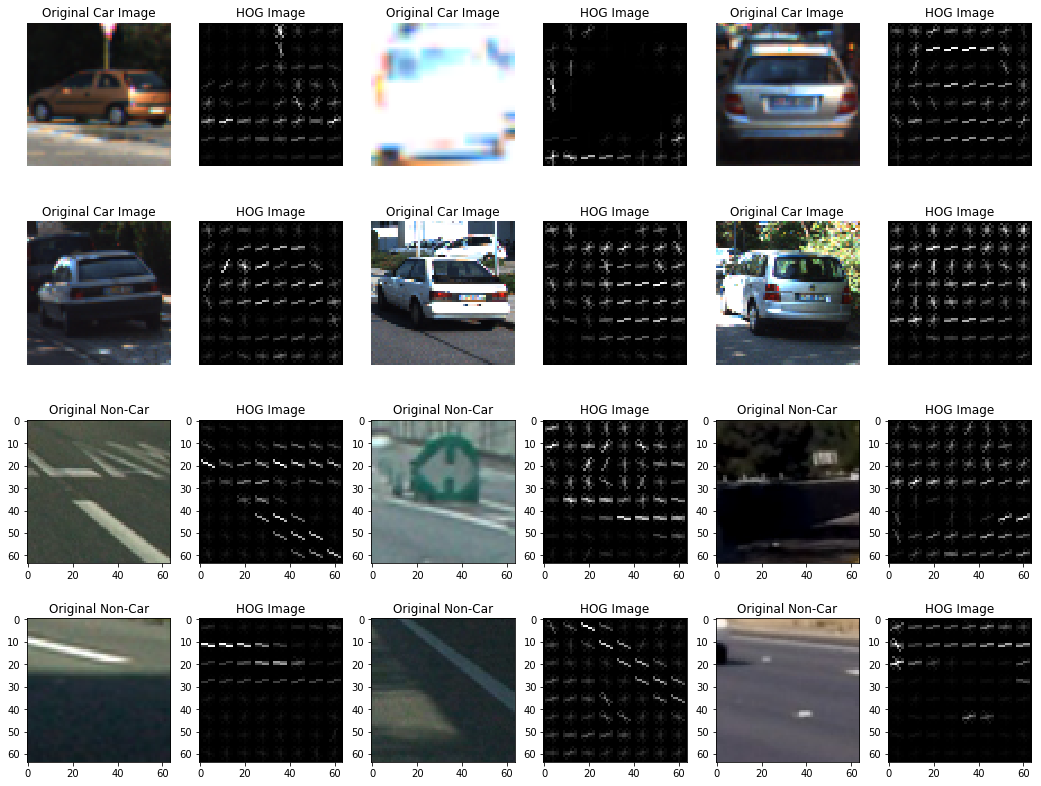

In [5]:
fig, axes = plt.subplots(4, 6, figsize=(18,14))
axes = axes.ravel()

for i in range(6):
    car_img = mpimg.imread(cars[np.random.randint(0,len(cars))])
    _, hog_car_img = get_hog_features(car_img[:,:,2], orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
    axes[i].axis('off')
    axes[2*i].imshow(car_img)
    axes[2*i].set_title("Original Car Image")
    axes[2*i+1].imshow(hog_car_img,cmap="gray")
    axes[2*i+1].set_title("HOG Image")

for i in range(6,12):
    notcar_img = mpimg.imread(notcars[np.random.randint(0,len(notcars))])
    _, hog_notcar_img = get_hog_features(notcar_img[:,:,2], orient=9, pix_per_cell=8, cell_per_block=2, vis=True, feature_vec=True)
    axes[i].axis('off')
    axes[2*i].imshow(notcar_img)
    axes[2*i].set_title("Original Non-Car")
    axes[2*i+1].imshow(hog_notcar_img,cmap="gray")
    axes[2*i+1].set_title("HOG Image")

**Extract Features and concatenate them**

In [6]:
def convert_color(img, conv):
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: return img


In [7]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            feature_image = convert_color(image, conv=color_space)
        else: feature_image = np.copy(image)     

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

**Define the parameters and extract features for our images' data**

In [9]:
import pickle
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = (0, 1)

spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)


# Stack car and not-car features together
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Train Accuracy of SVC = ', round(svc.score(X_train, y_train), 4))
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Dump the data as a pickle file
data_dict = {"svc": svc, "scaler": X_scaler, "orient": orient, "pix_per_cell": pix_per_cell, "cell_per_block": cell_per_block,
                "spatial_size": spatial_size, "hist_bins": hist_bins}
pickle.dump(data_dict, open("svc_pickle.p", "wb"))

/home/mlab-gaming/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 11 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 7239
24.14 Seconds to train SVC...
Train Accuracy of SVC =  1.0
Test Accuracy of SVC =  0.9893


**Sliding Window Implementation**

In [10]:
# Define a function that takes an image, start and stop positions in both x and y, 
# window size (x and y dimensions) and overlap fraction (for both x and y)
def slide_window(img, y_start=None, y_stop=None, x_start=None, x_stop=None, 
                 xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If y start/stop positions not defined, set to image size
    if y_start == None:
        y_start = 0
    if y_stop == None:
        y_stop = img.shape[0]
    if x_start == None:
        x_start = 0
    if x_stop == None:
        x_stop = img.shape[1]
    # Compute the span of the region to be searched    
    xspan = x_stop - x_start
    yspan = y_stop - y_start
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

**Visualize an image with boxes drawn on it**

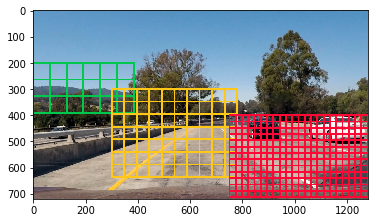

In [11]:
image = mpimg.imread('test_images/test1.jpg')

windows = slide_window(image, y_start=200, y_stop=400,
                       x_start=0, x_stop=400, xy_window=(128, 128), xy_overlap=(0.5, 0.5))
window_img = draw_boxes(image, windows, color=(0, 200, 78), thick=6)

windows2 = slide_window(image, y_start=300, y_stop=650,
                       x_start=300, x_stop=800, xy_window=(96, 96), xy_overlap=(0.5, 0.5))
window_img2 = draw_boxes(window_img, windows2, color=(255, 200, 24), thick=6)

windows3 = slide_window(image, y_start=400, y_stop=None,
                       x_start=750, x_stop=None, xy_window=(48, 48), xy_overlap=(0.5, 0.5))
window_img3 = draw_boxes(window_img2, windows3, color=(255, 8, 54), thick=6)


plt.imshow(window_img3)

**Multi-Scale Windows**

In [12]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        feature_image = convert_color(img, conv=color_space)
    else: feature_image = np.copy(img)   
#     if color_space != 'RGB':
#         if color_space == 'HSV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#         elif color_space == 'LUV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
#         elif color_space == 'HLS':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#         elif color_space == 'YUV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
#         elif color_space == 'YCrCb':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
#     else: feature_image = np.copy(img)  
    
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

**Use our Machine Learning Classifier to predict location**

In [13]:
# Define a function you will pass an image and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='HLS', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    # .png images are read in the range of 0 to 1, converting the test jpg images to the same range
    img = img.astype(np.float32)/255
    
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

/home/mlab-gaming/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


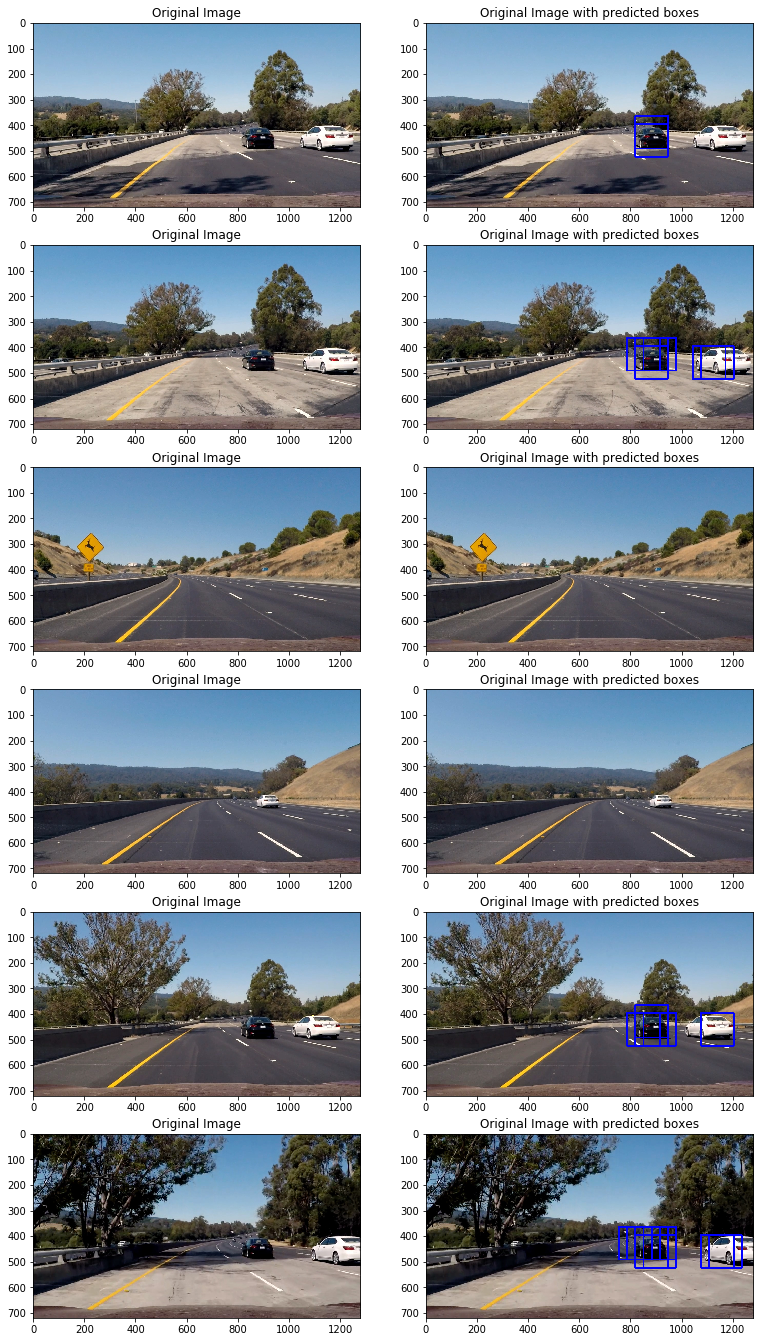

In [14]:
# Define a single function that can extract features using hog sub-sampling and make predictions
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins,color=(0,0,255)):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    # store rectangles in this array
    boxes = []
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='HLS')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                boxes.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),color,6) 
                
    return boxes, draw_img


ystart = 300
ystop = 656
xstart = 400
xstop = 1280
scale = 2
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

images = glob.glob('test_images/*.jpg')

fig, axes = plt.subplots(len(images), 2, figsize=(10,20))
axes = axes.ravel()
# [ax.axis("off") for ax in axes]
for i, fname in enumerate(images):
    img = mpimg.imread(fname)
    _, out_img = find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    axes[2*i].imshow(img)
    axes[2*i].set_title("Original Image")
    axes[2*i+1].imshow(out_img)
    axes[2*i+1].set_title("Original Image with predicted boxes")
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [15]:
# I would have used this function had I not used the function "find_cars" above. This one is slower for videos

def img_with_window(image, y_start=image.shape[0]//2, y_stop=None, x_start=None, x_stop=None, 
                    xy_window=(48, 48), xy_overlap=(0.5, 0.5), color=(0, 0, 256)):
    draw_image = np.copy(image)
    windows = slide_window(image, y_start, y_stop, x_start, x_stop, xy_window, xy_overlap)
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=color, thick=6)                    

    return hot_windows, window_img



# images = glob.glob('test_images/*.jpg')
# fig, axes = plt.subplots(len(images), 2, figsize=(10,20))
# axes = axes.ravel()
# # [ax.axis("off") for ax in axes]
# for i, fname in enumerate(images):
#     img = mpimg.imread(fname)
#     _, window_img = img_with_window(img)
#     axes[2*i].imshow(img)
#     axes[2*i].set_title("Original Image")
#     axes[2*i+1].imshow(window_img)
#     axes[2*i+1].set_title("Original Image with predicted boxes")
# plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

**Multiple Detections & False Positives**

It is clear from above that there are multiple detections as well as lots of False Positives found. A remedy for this is to add heat and consider only the windows that are detected by multiple window sizes. (leaving the wrongly detected windows cold)


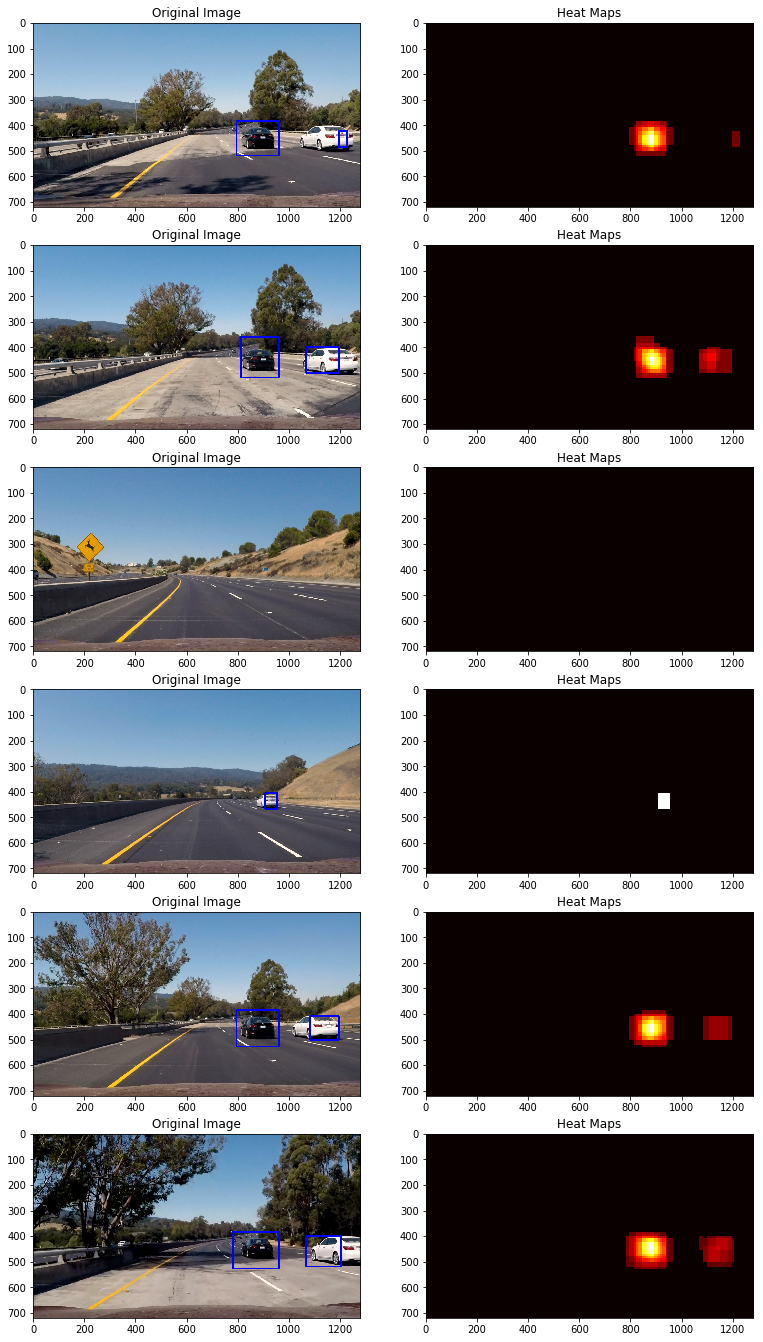

In [27]:
from scipy.ndimage.measurements import label

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


# def box_list_fun(img):
#     box_list = []
#     hot_window1, _ = img_with_window(img, y_start=360, y_stop=500, x_start=600, x_stop=None,
#                                     xy_window=(64, 64), xy_overlap=(0.6, 0.6))
    
#     hot_window2, _ = img_with_window(img, y_start=300, y_stop=500, x_start=600, x_stop=None,
#                                     xy_window=(96, 96), xy_overlap=(0.8, 0.8))
    
#     hot_window3, _ = img_with_window(img, y_start=400, y_stop=550, x_start=600, x_stop=None,
#                                      xy_window=(128, 128), xy_overlap=(0.9, 0.9))
    
#     hot_window4, _ = img_with_window(img, y_start=360, y_stop=500, x_start=800, x_stop=None,
#                                     xy_window=(48, 48), xy_overlap=(0.7, 0.7))

#     hot_window5, _ = img_with_window(img, y_start=400, y_stop=600, x_start=50, x_stop=400,
#                                     xy_window=(64, 64), xy_overlap=(0.6, 0.6))
    
#     box_list= hot_window1 + hot_window2 + hot_window3 + hot_window4 + hot_window5
    
#     return box_list


def box_list_fun(img): # Find cars doesn't have xy overlap so I am defining multi-same scale functions
    box_list = []
#     hot_window1, _ = find_cars(img, ystart=360, ystop=500, xstart= 750, xstop=1280, scale=0.75, svc=svc, 
#                                X_scaler=X_scaler, orient=orient, pix_per_cell=pix_per_cell,
#                                cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins)
    hot_window2, _ = find_cars(img, ystart=400, ystop=470, xstart= 50, xstop=450, scale=1, svc=svc,
                               X_scaler=X_scaler, orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins)
    hot_window3, _ = find_cars(img, ystart=360, ystop=520, xstart= 650, xstop=1280, scale=1, svc=svc,
                               X_scaler=X_scaler, orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins)
    hot_window4, _ = find_cars(img, ystart=360, ystop=550, xstart= 650, xstop=1280, scale=1.5, svc=svc,
                               X_scaler=X_scaler, orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins)
    hot_window5, _ = find_cars(img, ystart=400, ystop=600, xstart= 650, xstop=1280, scale=2, svc=svc,
                               X_scaler=X_scaler, orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins)
    hot_window6, _ = find_cars(img, ystart=360, ystop=656, xstart= 700, xstop=1280, scale=2.5, svc=svc,
                               X_scaler=X_scaler, orient=orient, pix_per_cell=pix_per_cell,
                               cell_per_block=cell_per_block, spatial_size=spatial_size, hist_bins=hist_bins)

    box_list= hot_window2 + hot_window3 + hot_window4 + hot_window5 + hot_window6
    
    return box_list

    
def draw_heatmap(image):
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    box_list = box_list_fun(image)
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img, heatmap


images = glob.glob('test_images/*.jpg')
fig, axes = plt.subplots(len(images), 2, figsize=(10,20))
axes = axes.ravel()
# [ax.axis("off") for ax in axes]
for i, fname in enumerate(images):
    img = mpimg.imread(fname)
    draw_img, heatmap = draw_heatmap(img)
    axes[2*i].imshow(draw_img)
    axes[2*i].set_title("Original Image")
    axes[2*i+1].imshow(heatmap, cmap='hot')
    axes[2*i+1].set_title("Heat Maps")
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


**Test on Videos**

In [17]:
from P4_Advanced_Lane_Lines import *
def vid_processing(image):
    
    image = video_pipeline(image)
    
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    box_list = box_list_fun(image)
    heat = add_heat(heat,box_list)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

In [18]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import os

In [19]:
# Create output directory if it doesn't exist
if not os.path.exists("test_videos_output"):
    os.makedirs("test_videos_output")
white_output = 'test_videos_output/testVideoOutput.mp4'

##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(vid_processing)
%time white_clip.write_videofile(white_output, audio=False)    


[MoviePy] >>>> Building video test_videos_output/testVideoOutput.mp4
[MoviePy] Writing video test_videos_output/testVideoOutput.mp4


 97%|█████████▋| 38/39 [00:55<00:01,  1.56s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/testVideoOutput.mp4 

CPU times: user 2min 17s, sys: 464 ms, total: 2min 17s
Wall time: 56.4 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [21]:
white_output2 = 'test_videos_output/ProjectVideoOutput.mp4'

##clip1 = VideoFileClip("test_videos/s<img src="./output_images/DefaultBoxes.png">
olidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("project_video.mp4")
white_clip2 = clip2.fl_image(vid_processing)
%time white_clip2.write_videofile(white_output2, audio=False) 

[MoviePy] >>>> Building video test_videos_output/ProjectVideoOutput.mp4
[MoviePy] Writing video test_videos_output/ProjectVideoOutput.mp4


100%|█████████▉| 1260/1261 [29:33<00:01,  1.43s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/ProjectVideoOutput.mp4 

CPU times: user 1h 14min 36s, sys: 9.43 s, total: 1h 14min 45s
Wall time: 29min 34s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output2))